# Detecting Gravitional Waves Using Topological algorithms

Authors:
* Christian Jaffé Alarcón Acosta - A00832881
* José Andrés Orantes Guillén - A01174130
* Juan José Montes Raygoza - A00834630
* Pedro Fernández Merino - A01733006
* Rubén Darío Castro Terrazas - A00833945



### Import libraries and dependencies

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from data.generate_datasets import make_gravitational_waves
from pathlib import Path
from plotly.subplots import make_subplots
import plotly.graph_objects as go


### Motivation


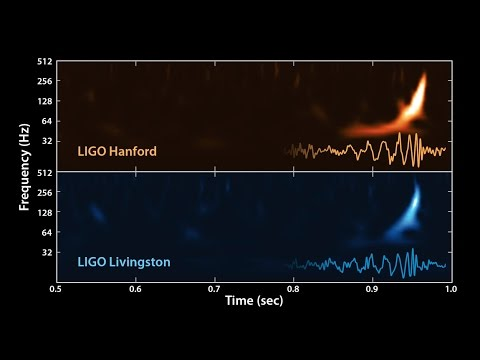

In [11]:
from IPython.display import YouTubeVideo

YouTubeVideo("Y3eR49ogsF0", width=600, height=400)
YouTubeVideo("QyDcTbR-kEA", width=600, height=400)

### Generate the data

The data was obtanined from the giotto-tda library: https://github.com/giotto-ai/giotto-tda/blob/master/examples/gravitational_waves_detection.ipynb

In [6]:

R = 0.65
n_signals = 100
DATA = Path("./data")

noisy_signals, gw_signals, labels = make_gravitational_waves(
    path_to_data=DATA, n_signals=n_signals, r_min=R, r_max=R, n_snr_values=1
)

print(f"Number of noisy signals: {len(noisy_signals)}")
print(f"Number of timesteps per series: {len(noisy_signals[0])}")

Number of noisy signals: 100
Number of timesteps per series: 8692


Plot the data (gravitational waves)

In [8]:
# get the index corresponding to the first pure noise time series
background_idx = np.argmin(labels)
# get the index corresponding to the first noise + gravitational wave time series
signal_idx = np.argmax(labels)

ts_noise = noisy_signals[background_idx]
ts_background = noisy_signals[signal_idx]
ts_signal = gw_signals[signal_idx]

fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Scatter(x=list(range(len(ts_noise))), y=ts_noise, mode="lines", name="noise"),
    row=1,
    col=1,
)

fig.add_trace(
    go.Scatter(
        x=list(range(len(ts_background))),
        y=ts_background,
        mode="lines",
        name="background",
    ),
    row=1,
    col=2,
)

fig.add_trace(
    go.Scatter(x=list(range(len(ts_signal))), y=ts_signal, mode="lines", name="signal"),
    row=1,
    col=2,
)
fig.show()